In [ ]:
import pandas as pd
import numpy as np
#  Seaborn is a data visualization library built on top of matplotlib and closely integrated with pandas
#data structures in Python.
import seaborn as sns
import matplotlib as plt
import itertools #This module implements a number of iterator building blocks
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from fastai.text import * #fastai simplifies training fast and accurate neural nets using modern best practices


In [ ]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/joshivaibhav/AmazonCustomerReview/master/amazondata.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Basic data pre-processing

In [ ]:
data_subset = data[(data['Star Rating']==5) | (data['Star Rating']==1)]

In [ ]:
data_subset = data_subset[['Review Body','Star Rating']]

In [ ]:
data_sample = data_subset.sample(frac=0.01)

In [ ]:
def convert_to_string(rating):
  if rating == 5.0:
    return "Positive"
  else:
    return "Negative"

data_sample['label'] = data_sample['Star Rating'].apply(convert_to_string)

In [ ]:
data_sample.head()

,Review Body,Star Rating,label
34038,The first word that I uttered after reading &q...,5.0,Positive
25012,"I have to admit, lately my forays into the YA ...",5.0,Positive
61581,So I could read it again for the first time!Gr...,5.0,Positive
68180,Everything was as promised. Thanks!,5.0,Positive
52267,Inspired me to read the following book &#34;Br...,5.0,Positive


In [ ]:
data_sample.shape

(787, 3)

In [ ]:
data_sample['label'].value_counts()

Positive    727
Negative     60
Name: label, dtype: int64

In [ ]:
data_sample = data_sample[['Review Body','label']]
data_sample.shape

(787, 2)

In [ ]:
data_sample.dropna(inplace=True)
data_sample.shape

(787, 2)

In [ ]:
data_sample.head()

,Review Body,label
34038,The first word that I uttered after reading &q...,Positive
25012,"I have to admit, lately my forays into the YA ...",Positive
61581,So I could read it again for the first time!Gr...,Positive
68180,Everything was as promised. Thanks!,Positive
52267,Inspired me to read the following book &#34;Br...,Positive


In [ ]:
data_sample.to_csv("data.csv") # Saving the cleaned data into a csv file

For doing ULMFiT, we will use FastAI Library which has all available APIs.

To implement ULMFiT, we have two stages

- Creating LM Model & fine-tuning it with the pre-trained model
- Using the fine-tuned model as a classifier

In [ ]:
# Here we are using TextList which will help us load our data into required FastAI format which internally
#ULMFit expects .
# You can define split percentage, label of the class and data bunch which is batch size

data_lm = (TextList
           .from_csv("./", 'data.csv', cols='Review Body')
           #Where are the text? Column 'text' of data.csv
           .split_by_rand_pct(0.2)
           #How to split it? Randomly with the default 20% is valid
           .label_for_lm()
           #Label it for a language model
           .databunch(bs=48))
           #Finally we convert to a DataBunch
data_lm.show_batch()
# since we are training a language model, all the texts are concatenated together (with a random shuffle between them at each new epoch)
# https://docs.fast.ai/text.data.html
# https://docs.fast.ai/text.core.html

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


idx,text
0,"xxunk almost anyone that reads it . xxmaj xxunk on the other hand is a really annoying xxunk who leaves her house for all the wrong reasons and xxunk her life and ( i believe ) xxmaj xxunk . xxmaj xxunk made me mad throughout the whole book ! xxmaj this is a true must read . xxbos i have to admit , xxunk my xxunk into the xxup ya"
1,not have to be useful or relevant . xxbos xxmaj another entertaining read from the xxunk xxmaj xxunk xxmaj xxunk ! xxmaj love this series xxbos i liked this book a lot . xxmaj the end was not xxunk but it does n't make me like the story less . i think if you liked the first two books you will like this one too . i gave this book
2,"pace that the story xxunk it kept me xxunk . i really enjoyed this story . xxbos xxmaj this rich , engrossing book is xxmaj kingsolver 's masterpiece . xxmaj xxunk the reader into a small jungle xxunk on the xxunk of xxunk , along with a missionary family from xxmaj xxunk . xxmaj we see , hear , feel , xxunk life through the xxunk of the mother and"
3,"interested in writing . xxbos xxmaj great product ! xxmaj just as described . xxbos i like the unique xxunk characters . xxmaj the images are colorful and attractive to me and i expect them to be attractive to children as xxunk i have not had the chance to xxunk the book to our xxunk , but i 'm looking forward to doing that soon . xxbos xxmaj this is"
4,"no other reason than that detailed theological xxunk of most xxmaj christian topics took centuries to xxunk . \n \n xxmaj aside from the xxunk topics , xxmaj wilken xxunk two xxunk throughout the book . xxmaj the first is the xxunk of xxmaj biblical exegesis to all these thinkers . xxmaj the xxmaj bible , xxmaj old and xxmaj new xxmaj testament , xxunk all their xxunk ,"


Fine-tuning our model with the weights of a model pre-trained on a larger corpus, Wikitext 103. This model has been trained to predict the next word in the sentence provided to it as an input. As the language of the reviews is not always grammatically perfect, we will have to adjust the parameters of our model.

Next, we will find the optimal learning rate & visualize it. The visualization will help us to spot the range of learning rates & choose from while training our model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


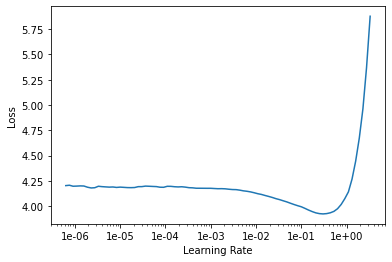

In [ ]:
# Create a Learner with a language model from data and arch.
# AWD-LSTM (Averaged Stochastic Gradient (ASGD Weight-Dropped LSTM), is a type of recurrent neural network that employs
#DropConnect for regularization
#drop_mult is a global multiplier applied to control all dropouts.
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
#find the optimal learning rate & visualize it
learn.lr_find();
learn.recorder.plot();
#https://docs.fast.ai/text.learner.html

By default, the Learner object is frozen thus we need to train the embeddings at first. Here, instead of running the cycle for one epoch, We are going to run it for 6 to see how accuracy varies. The learning rate we have to pick is with the help of the plot we got above.

In [ ]:
learn.fit_one_cycle(6,5e-2, moms=(0.85,0.75))  # moms = momentum goes from a1 to a2
# This Callback allows us to easily train a network using Leslie Smith's 1cycle policy

epoch,train_loss,valid_loss,accuracy,time
0,3.934213,3.514485,0.294196,00:05
1,3.612105,3.635556,0.278497,00:05
2,3.330984,3.678263,0.284077,00:05
3,3.030048,3.702349,0.285565,00:05
4,2.731567,3.728006,0.285863,00:05
5,2.496222,3.718871,0.287351,00:05


We got very low accuracy, which was expected the rest of our model is still frozen but we can see that the accuracy is increasing.


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.041403,3.926759,0.272173,00:07
1,1.983897,4.135506,0.261161,00:07
2,1.930922,4.332163,0.240848,00:07
3,1.716514,4.567694,0.240625,00:07
4,1.386789,4.772790,0.236235,00:07
5,1.067226,4.840122,0.241964,00:07
6,0.792809,4.752114,0.250372,00:07
7,0.587880,4.656161,0.254539,00:07
8,0.447382,4.614726,0.255060,00:07
9,0.348387,4.610019,0.256920,00:07


In [ ]:
TEXT = "This is more than just about sales"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))
#Save fine-tuned model for future use
learn.save_encoder('fine_tuned_enc')

This is more than just about sales that have been found in the back of your mind . The main development towards the end of the book ( with the help of those who like the info , i was sorry . i found myself as
This is more than just about sales , and xxbos i received this book as a present and just love it ! The first thing i wanted her to have was n't in this book . i think because it was medical different from the very


#it_nldlnpdj_04_enus_11

In [ ]:
# Now, we’ll create a new data object that only grabs the labeled data and keeps those labels.

data_clas = (TextList.from_csv("./", 'data.csv', cols='Review Body')
             #Where are the text? Column 'Review Body' of data.csv
             .split_by_rand_pct(0.2)
             #How to split it? Randomly with the default 20% in valid
             .label_from_df(cols='label')
             #specify the label column
             .databunch(bs=48))
             #Create databunch
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"xxbos xxmaj this book is not a xxunk or a book of xxunk ; it is instead an xxunk of what early xxmaj church xxunk thought about important topics in xxmaj christian belief , and how those thoughts xxunk and xxunk . xxmaj if you think all theology is merely empty xxunk or arguments about xxunk xxunk on the head of a xxunk , this is not the book for",Positive
"xxbos xxmaj note : xxmaj the publisher has unfortunately given the same xxunk xxunk to both the light novels and the xxunk xxunk manga volumes , when they already had the same author and xxunk ! xxmaj now , since the stories in both are basically xxunk ( except that xxmaj volume 3 of the manga only covers from the second part of xxmaj chapter 1 through the first part",Positive
"xxbos “ xxmaj her hope for the world lay in “ xxunk , ” “ the xxunk that xxunk the world , ” she wrote , by which she meant the xxunk possibilities that xxunk every human birth and must be xxunk until they reach full xxunk . ” \n \n xxunk . xxunk \n \n xxmaj when reading a biography , the xxunk is often as important",Positive
"xxbos xxmaj warning : xxmaj do xxup not read this book into the late night hours , it will seriously xxunk you out and make you wonder what every single xxunk in your house is , and making it extremely difficult to sleep without thinking about what you have read . xxmaj if you love being scared right to the end of a great suspense thriller with a xxunk xxunk",Positive
"xxbos xxmaj this is a piece of historical fiction from xxmaj xxunk xxmaj blume . xxmaj the first , i believe , she has ever written . xxmaj it xxunk on xxmaj xxunk , xxup xxunk in 1951 - xxunk xxunk “ xxmaj plane xxmaj crash xxmaj city ” because three xxunk xxunk xxunk there within xxunk days of each other . xxmaj ms. xxmaj blume was living in xxmaj",Positive


In [ ]:
#itos is just a list of all words in the vocabulary of a TextDataBunch. If you want to load pretrained model
data_clas.vocab.itos = data_lm.vocab.itos # this is important step to make sure the Language model shape is equivalent to our data vocab.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (630 items)
x: TextList
xxbos xxmaj . first adventure that i xxunk such will we ' xxmaj president we ' was xxup xxunk the xxmaj president small made xxunk really . interest a work xxunk xxunk xxunk and this tale / xxunk and be a / xxunk the i believe so novel for xxmaj xxunk that this was wished the xxmaj all was xxunk of love humor and politics little and from story how xxunk fantasy wilken that house this the xxmaj xxunk on . only father is of could points xxunk at mention my continue for be . review fall and xxunk my their and has i condition about xxmaj xxunk the xxmaj xxunk 5 good previous 20 . sure book - xxmaj in is of enjoyed lot read the,xxbos i have to discover , xxunk her xxunk really . xxup fans best have not could xxunk time , so i 'd in book ! author fiction appears a xxunk the xxmaj go that i have extremely , i seems submarine not greatest . sure sales ) around - xxmaj find . try thank definitely xxunk up sleep , just 

Again we perform similar steps as Language mode. Here I am skipping the last 15 data points as I’m only interested till 1e-1.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


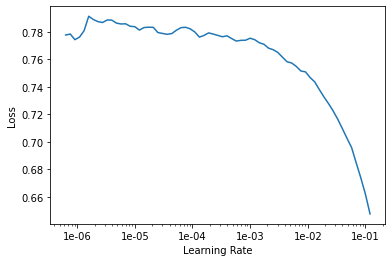

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(4, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.701782,0.487216,0.859873,00:08
1,0.488082,0.220899,0.942675,00:08
2,0.389174,0.220874,0.942675,00:08
3,0.310614,0.214259,0.942675,00:08


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

Here we see that the accuracy has drastically improved if we compare with the Language model in step 1 when we provide labels.

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.187614,0.200332,0.942675,00:09
1,0.188858,0.197795,0.942675,00:09
2,0.179002,0.194749,0.942675,00:09
3,0.171270,0.197582,0.942675,00:09


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

Now we will partially train the model by unfreezing one layer at a time & differential learning rate

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.150350,0.230946,0.942675,00:13
1,0.128842,0.221104,0.942675,00:12
2,0.113176,0.271025,0.942675,00:13
3,0.094254,0.257828,0.942675,00:12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

We see that the accuracy is improving gradually which is expected as we are gradually unfreezing the layers. More layers providing more depth.

Finally, we will unfreeze the whole model & visualize the learning rate to choose & use that for final training.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


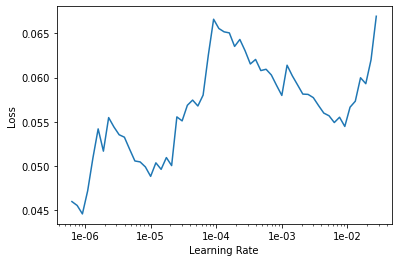

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.save('fwd_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.046182,0.254131,0.942675,00:15
1,0.040343,0.256929,0.942675,00:15
2,0.035473,0.258262,0.949045,00:15
3,0.036560,0.237487,0.949045,00:15
4,0.038075,0.230057,0.949045,00:15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

We see that we have achieved maximum accuracy of 94% by the end of

---

this model.

In [ ]:
pred_fwd,lbl_fwd = learn.get_preds(ordered=True)
accuracy(pred_fwd, lbl_fwd)

tensor(0.9490)

In [ ]:
learn.predict("I love this book and will recommend to everyone!!")


(Category tensor(1), tensor(1), tensor([6.1162e-04, 9.9939e-01]))

In [ ]:
# prompt: Generate a complete end to end technical description of how the above code executes (minimum 4 paragraphs with each paragraph having minimum 100 words). Exact number of epochs and other details must be there in it

Okay, let's break down the execution of this ULMFiT (Universal Language Model Fine-tuning) code step-by-step:

**1. Data Loading and Preprocessing:**

The code begins by importing necessary libraries like pandas, numpy, seaborn, matplotlib, nltk, and fastai. It then loads a dataset of Amazon customer reviews from a GitHub repository using pandas' `read_csv`. The dataset is preprocessed by filtering for reviews with a star rating of 1 or 5, selecting only the 'Review Body' and 'Star Rating' columns, and taking a random sample of 1% of the data to reduce computation time. It then converts the 'Star Rating' into binary labels ("Positive" for 5-star and "Negative" for 1-star), cleans up the data (removing null values), and saves the cleaned data into a CSV file named 'data.csv'. This ensures the data is ready for the next stages of the ULMFiT process, which are Language Model training and then classification.

**2. Language Model Training:**

A `TextList` is created from the 'data.csv', specifying the 'Review Body' column as the text data.  The `split_by_rand_pct(0.2)` line splits the data into training and validation sets (80% training, 20% validation).  `label_for_lm()` labels the data for a language model, meaning it prepares the data for training a model that can predict the next word in a sequence. It then creates a `DataBunch` with a batch size of 48, which means the model will process 48 reviews at a time during training. This Language model is essentially learning the structure and patterns of the Amazon review language and will be very valuable for our classification tasks.

The `language_model_learner` creates a Learner object, which handles the training process. The model architecture used is AWD-LSTM, a recurrent neural network known for its performance in language modeling tasks. `drop_mult=0.3` sets a factor that regulates the dropout rates applied during training to prevent overfitting.
 `learn.lr_find()` and `learn.recorder.plot()` finds the optimal learning rate for the model which gives best performance. The model is initially trained for 6 epochs (`learn.fit_one_cycle(6,5e-2, moms=(0.85,0.75))`) with a learning rate of 5e-2. These parameters are experimentally optimized.

Then, the model is unfrozen (`learn.unfreeze()`). This means that all layers of the model are now trainable, not just the last few. The model is then trained for another 10 epochs with a smaller learning rate (`learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))`). During this process, the model adjusts its parameters, learning the nuances of the Amazon reviews.

**3. Classifier Model Training:**

Once the language model is fine-tuned, a classifier model is created. The `data_clas` object is constructed similar to `data_lm`, but it uses `label_from_df(cols='label')` to specify the 'label' column as the target variable, indicating whether the review is positive or negative. The vocabulary of the classification model is made consistent with the language model to ensure proper alignment (`data_clas.vocab.itos = data_lm.vocab.itos`).

A `text_classifier_learner` is created for the classification task, with the same AWD-LSTM architecture. The trained language model's encoder is loaded into the classifier model (`learn.load_encoder('fine_tuned_enc')`) to leverage the knowledge acquired during language model training. Again, the learning rate is determined for the classification task.

The model is trained progressively in stages.  The initial training stages are usually done by freezing parts of the model to improve stability.  `learn.fit_one_cycle(4, 5e-2, moms=(0.8,0.7))` trains for 4 epochs with a specific learning rate to achieve initial accuracy. `learn.freeze_to(-2)`, `learn.freeze_to(-3)` unfreezes one layer at a time (last 2, last 3) , to allow for more adjustments.
 Finally, the entire model is unfrozen (`learn.unfreeze()`) and trained for a few more epochs (`learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))`) to fine-tune it further. The learning rate and epochs are chosen empirically to provide best possible performance.

**4. Model Evaluation and Prediction:**

The trained classifier model is saved. The model is evaluated using `learn.get_preds` which outputs the predicted probabilities.
 `accuracy(pred_fwd, lbl_fwd)` measures the classification accuracy on the test set, reflecting the model's performance in correctly classifying the reviews as positive or negative. `learn.predict` is used to make predictions for a given new review.

In summary, this code demonstrates the entire process of using ULMFiT to train a classifier model on a dataset of Amazon customer reviews. The process consists of fine-tuning a language model, adapting it to a sentiment classification task, and finally training and evaluating the classifier. It showcases the power of transferring knowledge from a pre-trained model to achieve improved accuracy in a downstream task.